# Identify Fraud from Enron Email
https://github.com/udacity/ud120-projects/tree/master/final_project

## Project Overview

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. 

In this project, we will attempt to identify "persons of interest" based on financial and email data made public as a result of the Enron scandal. We will build a "persons of interest" classifier to predict individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.


## Resources

- **poi_id.py** : Starter code for the POI identifier, you will write your analysis here. You will also submit a version of this file for your evaluator to verify your algorithm and results. 

- **final_project_dataset.pkl** : The dataset for the project, more details below. 

- **tester.py** : When you turn in your analysis for evaluation by Udacity, you will submit the algorithm, dataset and list of features that you use (these are created automatically in poi_id.py). The evaluator will then use this code to test your result, to make sure we see performance that’s similar to what you report. You don’t need to do anything with this code, but we provide it for transparency and for your reference. 

## Dataset

As preprocessing to this project, we've combined the Enron email and financial data into a dictionary, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

- **financial features**:  
`['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']`  
(all units are in US dollars)

- **email features**:  
`['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']`  
(units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

- **POI label**:  
`[‘poi’]`  
(boolean, represented as integer)

You are encouraged to make, transform or rescale new features from the starter features. If you do this, you should store the new feature to `my_dataset`, and if you use the new feature in the final algorithm, you should also add the feature name to `my_feature_list`.

In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("./tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

Select Features
----------------

In [2]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary'] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    try:
        data_dict = pickle.load(data_file)
        print "Successfully loaded data with {} samples & {} features".format(len(data_dict.keys()), 
                                                                              len(data_dict.values()[0]))
    except:
        print "Dataset could not be loaded. Is the dataset missing?"

Successfully loaded data with 146 samples & 21 features


### Look at the dict holding our data

In [106]:
print data_dict.keys()

['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY 

In [3]:
print data_dict['TOTAL']

{'salary': 26704229, 'to_messages': 'NaN', 'deferral_payments': 32083396, 'total_payments': 309886585, 'exercised_stock_options': 311764000, 'bonus': 97343619, 'restricted_stock': 130322299, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': -7576788, 'total_stock_value': 434509511, 'expenses': 5235198, 'loan_advances': 83925000, 'from_messages': 'NaN', 'other': 42667589, 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 1398517, 'deferred_income': -27992891, 'long_term_incentive': 48521928, 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'}


In [64]:
# create df from dict, don't remove any data
df = pd.DataFrame.from_dict(data_dict, orient='index')
print df.shape
df['poi'] = df.poi.astype(object)

display(df.head(3))

(146, 21)


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39


In [5]:
print df.index[84]
print df.ix['LOCKHART EUGENE E']

LOCKHART EUGENE E
salary                         NaN
to_messages                    NaN
deferral_payments              NaN
total_payments                 NaN
exercised_stock_options        NaN
bonus                          NaN
restricted_stock               NaN
shared_receipt_with_poi        NaN
restricted_stock_deferred      NaN
total_stock_value              NaN
expenses                       NaN
loan_advances                  NaN
from_messages                  NaN
other                          NaN
from_this_person_to_poi        NaN
poi                          False
director_fees                  NaN
deferred_income                NaN
long_term_incentive            NaN
email_address                  NaN
from_poi_to_this_person        NaN
Name: LOCKHART EUGENE E, dtype: object


In [8]:
# remove the guy with all nulls and the TOTAL
clean_dict = dict(data_dict)
del clean_dict['LOCKHART EUGENE E']
del clean_dict['TOTAL']
print 'data points: {}'.format(len(clean_dict))

persons = clean_dict.keys()
print 'persons: {}'.format(len(persons))

data points: 144
persons: 144


### Create features and labels

In [66]:
### Extract features and labels from dataset for local testing
features_list = ['poi','salary']
features_list.extend([i for i in data_dict.values()[0].keys() if i not in ['salary', 'poi', 'email_address']])

# create array of all data dict with nulls removed
#data = featureFormat(data_dict, features_list, sort_keys = True, remove_NaN=True)

# create array of cleaned data dict with nulls perserved
data = featureFormat(clean_dict, features_list, sort_keys = True, remove_NaN=False)
labels, features = targetFeatureSplit(data)

# create array of all data, with nulls removed
data_all = featureFormat(data_dict, features_list, sort_keys = True, remove_NaN=False)
y_all, X_all = targetFeatureSplit(data_all)

In [67]:
print len(features)
print len(labels)

144
144


In [68]:
# convert arrays with pandas
labels = pd.Series(labels)
features = pd.DataFrame(features, columns = features_list[1:])

print "Features: {}".format(features.shape)
print "Labels: {}\n".format(labels.shape)

# convert arrays with pandas
y_all = pd.Series(y_all)
X_all = pd.DataFrame(X_all, columns = features_list[1:])

print "All Features: {}".format(X_all.shape)
print "All Labels: {}".format(y_all.shape)

Features: (144, 19)
Labels: (144,)

All Features: (146, 19)
All Labels: (146,)


### Where is the row with all null values?

In [70]:
# where did the 1 instance go?
# http://stackoverflow.com/questions/20225110/comparing-two-dataframes-and-getting-the-differences
df_stack = pd.concat([features.fillna(0.), X_all.fillna(0.)]).reset_index(drop=True)
df_gpby = df_stack.groupby(list(df_stack.columns))
idx = [x[0] for x in df_gpby.groups.values() if len(x) == 1]
print idx
df_stack.reindex(idx)

[274, 228]


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
274,26704229.0,0.0,32083396.0,309886585.0,311764000.0,97343619.0,130322299.0,0.0,-7576788.0,434509511.0,5235198.0,83925000.0,0.0,42667589.0,0.0,1398517.0,-27992891.0,48521928.0,0.0
228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
print X_all.ix[84]
print y_all.ix[84]

salary                      NaN
to_messages                 NaN
deferral_payments           NaN
total_payments              NaN
exercised_stock_options     NaN
bonus                       NaN
restricted_stock            NaN
shared_receipt_with_poi     NaN
restricted_stock_deferred   NaN
total_stock_value           NaN
expenses                    NaN
loan_advances               NaN
from_messages               NaN
other                       NaN
from_this_person_to_poi     NaN
director_fees               NaN
deferred_income             NaN
long_term_incentive         NaN
from_poi_to_this_person     NaN
Name: 84, dtype: float64
0.0


In [71]:
df_all = pd.concat([features, pd.Series(labels, name='target')],axis=1)
print df_all.shape

# fill na with -1
df_all.fillna(-1, inplace=True)
df_all.head()

(144, 20)


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,target
0,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,13868.0,-1.0,2195.0,152.0,65.0,-1.0,-3081055.0,304805.0,47.0,0.0
1,-1.0,-1.0,178980.0,182466.0,257817.0,-1.0,-1.0,-1.0,-1.0,257817.0,3486.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
2,477.0,566.0,-1.0,916197.0,4046157.0,-1.0,1757552.0,465.0,-560222.0,5243487.0,56301.0,-1.0,29.0,864523.0,0.0,-1.0,-5104.0,-1.0,39.0,0.0
3,267102.0,-1.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,-1.0,-1.0,10623258.0,11200.0,-1.0,-1.0,2660303.0,-1.0,-1.0,-1386055.0,1586055.0,-1.0,0.0
4,239671.0,-1.0,260455.0,827696.0,-1.0,400000.0,145796.0,-1.0,-82782.0,63014.0,129142.0,-1.0,-1.0,69.0,-1.0,-1.0,-201641.0,-1.0,-1.0,0.0


In [27]:
# how many POI target are there?
print sum(df_all['target'])
sum(df_all['target']) / df_all.shape[0]

18.0


0.125

In [28]:
# summary stats
df_all.describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,target
count,1.440000e+02,144.000000,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,1.440000e+02,1.440000e+02,144.000000,1.440000e+02,144.000000,1.440000e+02,144.000000,144.000000,1.440000e+02,1.440000e+02,144.000000,144.000000
mean,1.854457e+05,1238.152778,2.220888e+05,2.259057e+06,2.075802e+06,6.759969e+05,8.685360e+05,702.208333,7.341702e+04,2.909785e+06,35374.993056,5.828115e+05,363.180556,2.972597e+05,24.222222,9979.430556,-1.936839e+05,3.369573e+05,38.354167,0.125000
std,1.970425e+05,2237.789367,7.541015e+05,8.846594e+06,4.795513e+06,1.233155e+06,2.016572e+06,1077.555346,1.301983e+06,6.189018e+06,45309.576030,6.794472e+06,1450.776974,1.131068e+06,79.904877,31300.860552,6.060109e+05,6.871828e+05,74.489730,0.331873
min,-1.000000e+00,-1.000000,-1.025000e+05,-1.000000e+00,-1.000000e+00,-1.000000e+00,-2.604490e+06,-1.000000,-1.787380e+06,-4.409300e+04,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000,-3.504386e+06,-1.000000e+00,-1.000000,0.000000
25%,-1.000000e+00,-1.000000,-1.000000e+00,9.964825e+04,-1.000000e+00,-1.000000e+00,2.434475e+04,-1.000000,-1.000000e+00,2.443265e+05,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000,-3.708600e+04,-1.000000e+00,-1.000000,0.000000
50%,2.105960e+05,347.500000,-1.000000e+00,9.413595e+05,6.082935e+05,3.000000e+05,3.605280e+05,114.000000,-1.000000e+00,9.659550e+05,20182.000000,-1.000000e+00,17.500000,9.595000e+02,0.000000,-1.000000,-1.000000e+00,-1.000000e+00,4.000000,0.000000
75%,2.696675e+05,1623.000000,8.535500e+03,1.945668e+06,1.683580e+06,8.000000e+05,7.374560e+05,933.750000,-1.000000e+00,2.295176e+06,53328.250000,-1.000000e+00,53.000000,1.505075e+05,14.000000,-1.000000,-1.000000e+00,3.745862e+05,41.250000,0.000000
max,1.111258e+06,15149.000000,6.426990e+06,1.035598e+08,3.434838e+07,8.000000e+06,1.476169e+07,5521.000000,1.545629e+07,4.911008e+07,228763.000000,8.152500e+07,14368.000000,1.035973e+07,609.000000,137864.000000,-1.000000e+00,5.145434e+06,528.000000,1.000000


In [29]:
df.isnull().values.any()

False

In [55]:
# any missing/null values
for col in features.columns:
    print col, sum(features[col].isnull())

salary 50
to_messages 58
deferral_payments 106
total_payments 20
exercised_stock_options 43
bonus 63
restricted_stock 35
shared_receipt_with_poi 58
restricted_stock_deferred 127
total_stock_value 19
expenses 50
loan_advances 141
from_messages 58
other 52
from_this_person_to_poi 58
director_fees 128
deferred_income 96
long_term_incentive 79
from_poi_to_this_person 58


### Fill null values in `features`

In [72]:
# keep a copy of original data
features_copy = features.copy()

# fill null values
features = features_copy.fillna(-1)

display(features.head(3))
display(features.tail(3))

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
0,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,13868.0,-1.0,2195.0,152.0,65.0,-1.0,-3081055.0,304805.0,47.0
1,-1.0,-1.0,178980.0,182466.0,257817.0,-1.0,-1.0,-1.0,-1.0,257817.0,3486.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,477.0,566.0,-1.0,916197.0,4046157.0,-1.0,1757552.0,465.0,-560222.0,5243487.0,56301.0,-1.0,29.0,864523.0,0.0,-1.0,-5104.0,-1.0,39.0


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
141,-1.0,-1.0,-1.0,-1.0,139130.0,-1.0,-1.0,-1.0,-1.0,139130.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
142,158403.0,-1.0,-1.0,360300.0,8308552.0,-1.0,3576206.0,-1.0,-1.0,11884758.0,53947.0,-1.0,-1.0,147950.0,-1.0,-1.0,-1.0,-1.0,-1.0
143,-1.0,-1.0,-1.0,55097.0,192758.0,-1.0,-1.0,-1.0,-1.0,192758.0,55097.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


Remove outliers
---------------

In [78]:
# start over if necessary
#features = features_copy.fillna(-1)

In [73]:
# what are low values in each feature?
for col in features.columns:
    print col, sorted(features[col].value_counts().index)[:5]

salary [-1.0, 477.0, 6615.0, 63744.0, 76399.0]
to_messages [-1.0, 57.0, 58.0, 102.0, 111.0]
deferral_payments [-102500.0, -1.0, 7961.0, 10259.0, 16586.0]
total_payments [-1.0, 148.0, 475.0, 1279.0, 2151.0]
exercised_stock_options [-1.0, 3285.0, 9803.0, 17378.0, 28798.0]
bonus [-1.0, 70000.0, 100000.0, 200000.0, 250000.0]
restricted_stock [-2604490.0, -1.0, 32460.0, 44093.0, 47304.0]
shared_receipt_with_poi [-1.0, 2.0, 3.0, 10.0, 12.0]
restricted_stock_deferred [-1787380.0, -560222.0, -472568.0, -409554.0, -329825.0]
total_stock_value [-44093.0, -1.0, 28798.0, 47304.0, 63014.0]
expenses [-1.0, 148.0, 475.0, 600.0, 1279.0]
loan_advances [-1.0, 400000.0, 2000000.0, 81525000.0]
from_messages [-1.0, 12.0, 13.0, 14.0, 15.0]
other [-1.0, 2.0, 69.0, 152.0, 162.0]
from_this_person_to_poi [-1.0, 0.0, 1.0, 2.0, 3.0]
director_fees [-1.0, 3285.0, 17500.0, 36666.0, 38346.0]
deferred_income [-3504386.0, -3367011.0, -3117011.0, -3081055.0, -2334434.0]
long_term_incentive [-1.0, 69223.0, 71023.0, 75000

In [74]:
# specify the columns with no zero values
cols_replace = [i for i in features.columns if i not in ['from_this_person_to_poi', 'from_poi_to_this_person']]
print cols_replace

['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'director_fees', 'deferred_income', 'long_term_incentive']


In [75]:
# replace -1 with 0 for features without any zero values
features[cols_replace] = features[cols_replace].replace([-1], [0])

display(features.head(3))
display(features.tail(3))

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
0,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,13868.0,0.0,2195.0,152.0,65.0,0.0,-3081055.0,304805.0,47.0
1,0.0,0.0,178980.0,182466.0,257817.0,0.0,0.0,0.0,0.0,257817.0,3486.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0
2,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,56301.0,0.0,29.0,864523.0,0.0,0.0,-5104.0,0.0,39.0


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
141,0.0,0.0,0.0,0.0,139130.0,0.0,0.0,0.0,0.0,139130.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0
142,158403.0,0.0,0.0,360300.0,8308552.0,0.0,3576206.0,0.0,0.0,11884758.0,53947.0,0.0,0.0,147950.0,-1.0,0.0,0.0,0.0,-1.0
143,0.0,0.0,0.0,55097.0,192758.0,0.0,0.0,0.0,0.0,192758.0,55097.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0


### TODO: log transform features
- normalize features with negative values
- add small constant to feature with min value 0


In [ ]:
# sign transform: take sqrt of absolute value


### Look at distributions

In [76]:
# separate financial and email features
fin_feats = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 
             'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 
             'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']

# removed 'email_address'
email_feats = ['to_messages', 'from_poi_to_this_person', 'from_messages', 
               'from_this_person_to_poi', 'shared_receipt_with_poi']

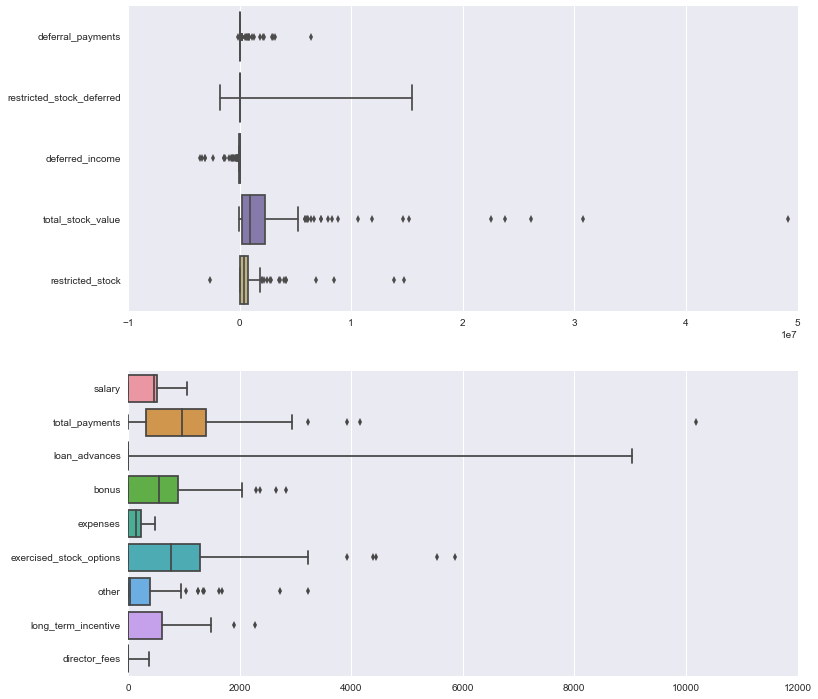

In [77]:
### Task 2: Remove outliers

neg_cols = [i for i in features.columns if min(features[i]) < 0]
pos_cols = [i for i in features.columns if min(features[i]) >= 0]

fin_pos = [i for i in fin_feats if i in pos_cols]
fin_neg = [i for i in fin_feats if i in neg_cols]

# boxplot of features
fig,ax = plt.subplots(2,1, figsize=(12,12))

sns.boxplot(features[fin_neg], orient='h', ax=ax[0])
sns.boxplot(np.sqrt(features[fin_pos]), orient='h', ax=ax[1]);

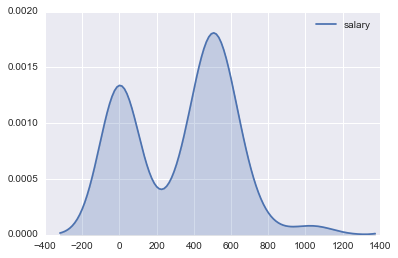

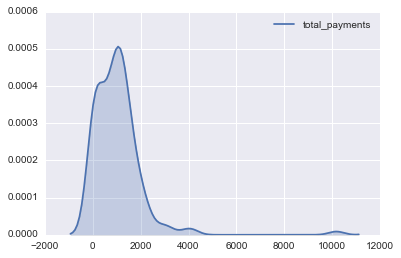

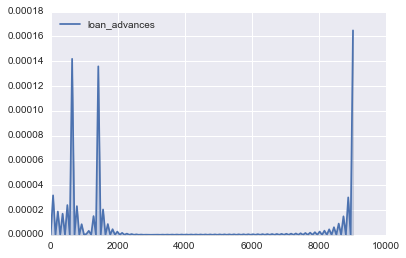

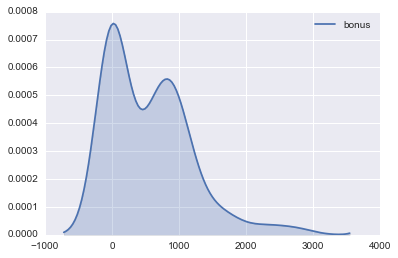

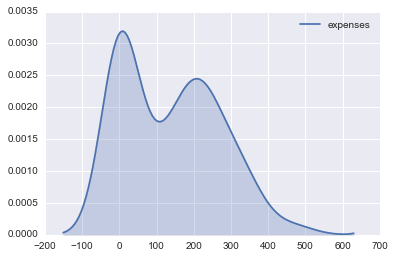

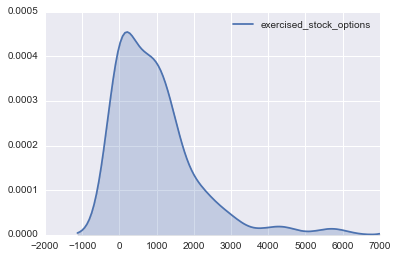

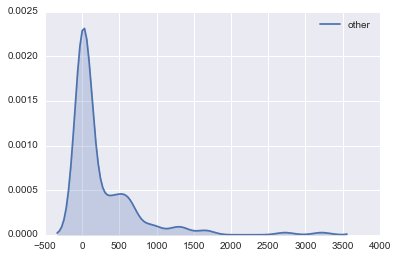

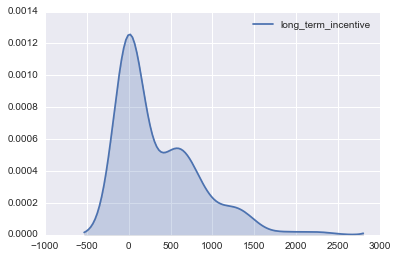

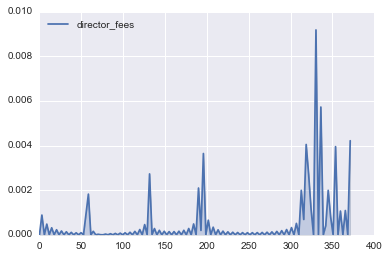

In [111]:
for i,col in enumerate(fin_pos):
    plt.figure()
    sns.kdeplot(np.sqrt(features[col]), shade=True);

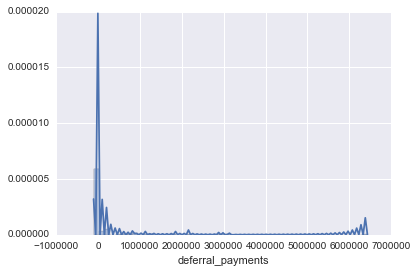

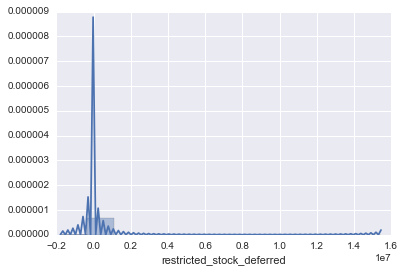

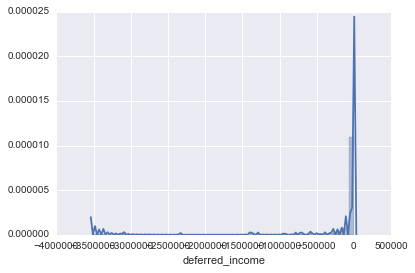

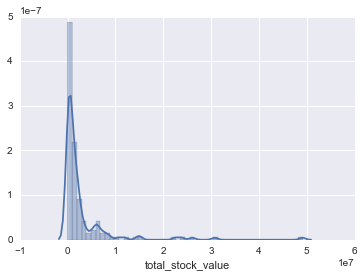

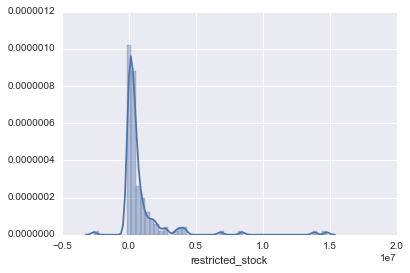

In [110]:
for i,col in enumerate(fin_neg):
    plt.figure()
    sns.distplot(features[col]);

In [78]:
# who are these outliers?
display(features[features.total_stock_value == max(features['total_stock_value'])])
display(features[features.restricted_stock == max(features['restricted_stock'])])

display(features[features.total_payments == max(features['total_payments'])])
display(features[features.exercised_stock_options == max(features['exercised_stock_options'])])

display(features[features.total_payments > 1e+8])

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
79,1072321.0,4273.0,202911.0,103559793.0,34348384.0,7000000.0,14761694.0,2411.0,0.0,49110078.0,99832.0,81525000.0,36.0,10359729.0,16.0,0.0,-300000.0,3600000.0,123.0


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
79,1072321.0,4273.0,202911.0,103559793.0,34348384.0,7000000.0,14761694.0,2411.0,0.0,49110078.0,99832.0,81525000.0,36.0,10359729.0,16.0,0.0,-300000.0,3600000.0,123.0


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
79,1072321.0,4273.0,202911.0,103559793.0,34348384.0,7000000.0,14761694.0,2411.0,0.0,49110078.0,99832.0,81525000.0,36.0,10359729.0,16.0,0.0,-300000.0,3600000.0,123.0


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
79,1072321.0,4273.0,202911.0,103559793.0,34348384.0,7000000.0,14761694.0,2411.0,0.0,49110078.0,99832.0,81525000.0,36.0,10359729.0,16.0,0.0,-300000.0,3600000.0,123.0


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
79,1072321.0,4273.0,202911.0,103559793.0,34348384.0,7000000.0,14761694.0,2411.0,0.0,49110078.0,99832.0,81525000.0,36.0,10359729.0,16.0,0.0,-300000.0,3600000.0,123.0


> Argh, it looks like one of the rows is "TOTAL"

In [79]:
# who is this person?
df[df.fillna(0).salary == 1072321]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
LAY KENNETH L,1072321,4273,202911,103559793,34348384,7000000,14761694,2411,NaN,49110078,...,81525000,36,10359729,16,True,NaN,-300000,3600000,kenneth.lay@enron.com,123


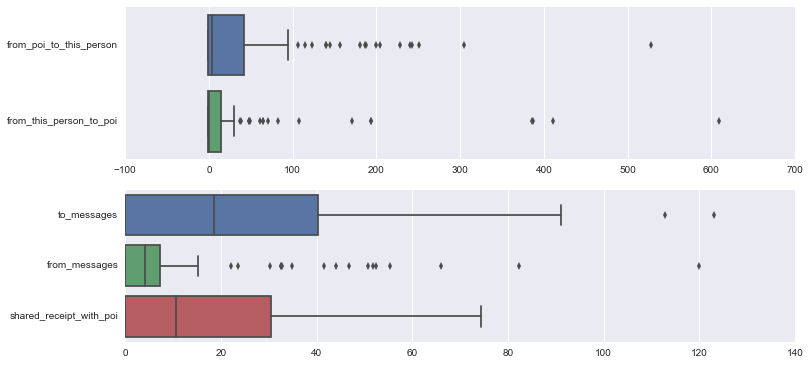

In [80]:
email_pos = [i for i in email_feats if i in pos_cols]
email_neg = [i for i in email_feats if i in neg_cols]

# boxplot of features
fig,ax = plt.subplots(2,1, figsize=(12,6))

sns.boxplot(features[email_neg], orient='h', ax=ax[0])
sns.boxplot(np.sqrt(features[email_pos]), orient='h', ax=ax[1]);

In [81]:
# TODO: who are these outliers
display(features[features.from_poi_to_this_person == max(features['from_poi_to_this_person'])])
display(features[features.from_this_person_to_poi == max(features['from_this_person_to_poi'])])
display(features[features.from_messages == max(features['from_messages'])])

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
78,339288.0,7259.0,0.0,10425757.0,4158995.0,8000000.0,1008149.0,3962.0,0.0,5167144.0,49537.0,0.0,2585.0,1552.0,411.0,0.0,0.0,2035380.0,528.0


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
31,365163.0,3093.0,0.0,4747979.0,2291113.0,3000000.0,1323148.0,2097.0,0.0,3614261.0,86174.0,0.0,3069.0,1661.0,609.0,0.0,0.0,1294981.0,66.0


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
72,275101.0,4607.0,0.0,1086821.0,850010.0,400000.0,126027.0,583.0,0.0,976037.0,83585.0,0.0,14368.0,4669.0,171.0,0.0,0.0,323466.0,41.0


In [83]:
# who are these people?
display(df[df.fillna(0).from_poi_to_this_person == max(features['from_poi_to_this_person'])])
display(df[df.fillna(0).from_this_person_to_poi == max(features['from_this_person_to_poi'])])
display(df[df.fillna(0).from_messages == max(features['from_messages'])])

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
LAVORATO JOHN J,339288,7259,NaN,10425757,4158995,8000000,1008149,3962,NaN,5167144,...,NaN,2585,1552,411,False,NaN,NaN,2035380,john.lavorato@enron.com,528


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
DELAINEY DAVID W,365163,3093,NaN,4747979,2291113,3000000,1323148,2097,NaN,3614261,...,NaN,3069,1661,609,True,NaN,NaN,1294981,david.delainey@enron.com,66


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
KAMINSKI WINCENTY J,275101,4607,NaN,1086821,850010,400000,126027,583,NaN,976037,...,NaN,14368,4669,171,False,NaN,NaN,323466,vince.kaminski@enron.com,41


Feature Selection
---------

### [Univariate feature selection using SelectKBest](http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)



In [112]:
from sklearn.feature_selection import SelectKBest

kbest = SelectKBest()
X_new = kbest.fit_transform(features, labels)
print X_new.shape
display(kbest.scores_)
display(kbest.pvalues_)

(144, 10)


array([ 18.57570327,   1.69882435,   0.21705893,   8.86672154,
        25.09754153,  21.06000171,   9.34670079,   8.74648553,
         0.06498431,  24.46765405,   6.23420114,   7.2427304 ,
         0.1641645 ,   4.20497086,   2.45139022,   2.10765594,
        11.59554766,  10.07245453,   5.36679629])

array([  3.03379611e-05,   1.94551115e-01,   6.42003894e-01,
         3.41592137e-03,   1.59454385e-06,   9.70247434e-06,
         2.66996114e-03,   3.63440202e-03,   7.99153557e-01,
         2.10580665e-06,   1.36731509e-02,   7.97381626e-03,
         6.85960708e-01,   4.21447009e-02,   1.19646644e-01,
         1.48769495e-01,   8.59803144e-04,   1.84543515e-03,
         2.19542725e-02])

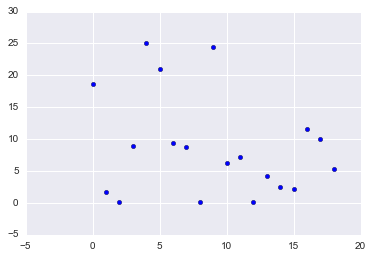

In [113]:
# visually inspect for high scores
plt.scatter(x=range(features.shape[1]), y=kbest.scores_);

In [114]:
# refit with new k
best_k = 4
kbest = SelectKBest(k=best_k)
X_new = kbest.fit_transform(features, labels)

# find best features
best_idx = np.argsort(kbest.scores_)[-1:(0-best_k-1):-1]
print best_idx
print sorted(best_idx)
print np.argsort(kbest.scores_)

[4 9 5 0]
[0, 4, 5, 9]
[ 8 12  2  1 15 14 13 18 10 11  7  3  6 17 16  0  5  9  4]


In [115]:
# look at dataframe of new feature set
df_new = pd.DataFrame(X_new, columns=features.columns[sorted(best_idx)])
df_new.head()

,salary,exercised_stock_options,bonus,total_stock_value
0,201955.0,1729541.0,4175000.0,1729541.0
1,0.0,257817.0,0.0,257817.0
2,477.0,4046157.0,0.0,5243487.0
3,267102.0,6680544.0,1200000.0,10623258.0
4,239671.0,0.0,400000.0,63014.0


### What are best features if we remove Ken Lay?

In [116]:
### Task 2: Remove outliers

# row 79 is Ken Lay
features[features.total_payments==max(features.total_payments)]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
79,1072321.0,4273.0,202911.0,103559793.0,34348384.0,7000000.0,14761694.0,2411.0,0.0,49110078.0,99832.0,81525000.0,36.0,10359729.0,16.0,0.0,-300000.0,3600000.0,123.0


In [117]:
# create new sets without Ken Lay
reduced_features = features.drop([79]).reset_index(drop=True)
print reduced_features.shape

reduced_labels = labels.drop([79]).reset_index(drop=True)
print reduced_labels.shape

(143, 19)
(143,)


Best indices: [ 4  9  5  0 16]
Best scores: [13  8 12 11  2  1  3 15 14  6 18 10 17  7 16  0  5  9  4]


,salary,exercised_stock_options,bonus,total_stock_value,deferred_income
0,201955.0,1729541.0,4175000.0,1729541.0,-3081055.0
1,0.0,257817.0,0.0,257817.0,0.0
2,477.0,4046157.0,0.0,5243487.0,-5104.0
3,267102.0,6680544.0,1200000.0,10623258.0,-1386055.0
4,239671.0,0.0,400000.0,63014.0,-201641.0


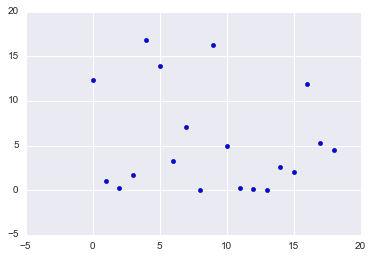

In [118]:
# refit with new k
def SelectK(best_k=5, features=features, labels=labels):
    kbest = SelectKBest(k=best_k)
    X_new = kbest.fit_transform(features, labels)

    # find best features
    best_idx = np.argsort(kbest.scores_)[-1:(0-best_k-1):-1]
    print 'Best indices: {}'.format(best_idx)
    #print sorted(best_idx)
    best_scores = kbest.scores_
    print 'Best scores: {}'.format(np.argsort(kbest.scores_))
    
    return best_idx, best_scores, kbest

# look at dataframe of new feature set
best_idx, best_scores, kbest = SelectK(5, reduced_features, reduced_labels)
X_new = kbest.fit_transform(reduced_features, reduced_labels)
df_new = pd.DataFrame(X_new, columns=reduced_features.columns[sorted(best_idx)])
display(df_new.head())

# visually inspect for high scores
plt.scatter(x=range(features.shape[1]), y=best_scores);

### Look at feature correlations

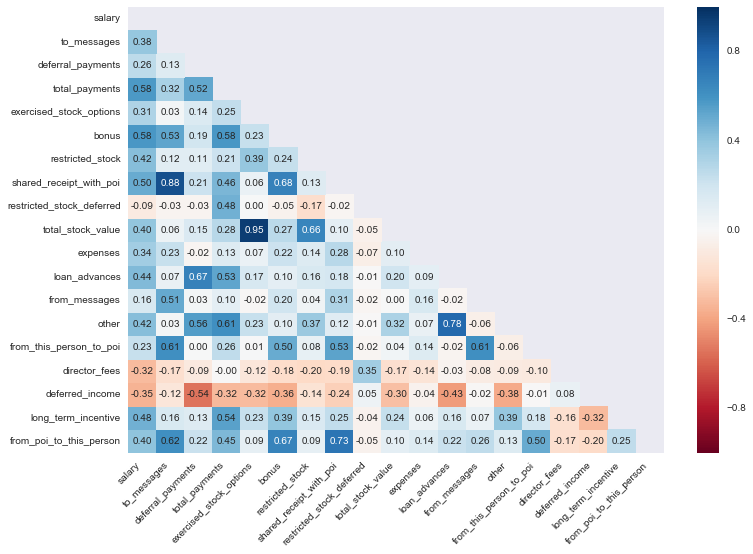

In [67]:
# look at feature correlations
corr = reduced_features.corr()

fig,ax = plt.subplots(1,1, figsize=(12,8))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=False, annot=True, cmap='RdBu', fmt='.2f')
    plt.xticks(rotation=45, ha='right');

### [Recursive Feature Elimination (RFE)](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)


Create new features
-------------------
### [Generate polynomial and interaction features](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

In [119]:
from sklearn.preprocessing import PolynomialFeatures

# change the polynomial degree
deg = 2
poly = PolynomialFeatures(deg)

# use original features
X_poly = poly.fit_transform(features)

# use SelectKBest features
#X_poly = poly.fit_transform(X_new)

print X_poly.shape

(144, 210)


Best indices: [  0 202 178 115 147  35  90   5  10  95]
Best scores: [158  71 192 186  46  98 125  39 133 199  94  58 167  32   9  64 137  61
  68  59 149  73  22  52  65 184 112  67 128  79 151  70 191 140 144  86
  13 185 121 182  53  57  83 187 148   3  72 145 101 150 152  28 188 153
  50 170 161 108 154  48 146  63 209 183  62  40 165  56 201  60  45 196
 139   2  69 194 127 200 203 114 208  16 118  87  15 143 195 207 198 138
 173 135  34  66 169 206  36  33  14 160  85 193 119 189  51 132  19 129
 197 168 171 100  38  21 126  11 179  55 159  99 113  44  84  54  89 181
 136  12  31 166 175  49 176 180 177  97 157 111 124  82 174  74 104  43
  88  75  80  77 141 164 190  23  81 142 131   8  76  41 162   4 123 102
   7  78 204  18 122 116 105 107  27 120  47  17 205  92  30  42 110  20
 130 106 134  26 117  93 109 163 103  91  29  37  24   1  25 155   6 156
 172  96  95  10   5  90  35 147 115 178 202   0]


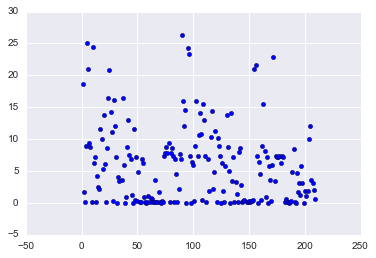

In [126]:
# look at dataframe of new feature set
best_idx, best_scores, kbest = SelectK(10, X_poly, labels)
X_poly_best = kbest.fit_transform(X_poly, labels)

# visually inspect for high scores
plt.scatter(x=range(X_poly.shape[1]), y=best_scores);

Store new features to `my_dataset`
-----

In [54]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
features_list = ['poi','salary']
features_list.extend([i for i in my_dataset.values()[0].keys() if i not in ['salary', 'poi', 'email_address']])

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Convert with pandas
import pandas as pd

labels = pd.Series(labels)
features = pd.DataFrame(features, columns = features_list[1:])

print "Features: {}".format(features.shape)
print "Labels: {}".format(labels.shape)

Features: (145, 19)
Labels: (145,)


In [25]:
features.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
0,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,13868,0,2195,152,65,0,-3081055,304805,47
1,0,0,178980,182466,257817,0,0,0,0,257817,3486,0,0,0,0,0,0,0,0
2,477,566,0,916197,4046157,0,1757552,465,-560222,5243487,56301,0,29,864523,0,0,-5104,0,39
3,267102,0,1295738,5634343,6680544,1200000,3942714,0,0,10623258,11200,0,0,2660303,0,0,-1386055,1586055,0
4,239671,0,260455,827696,0,400000,145796,0,-82782,63014,129142,0,0,69,0,0,-201641,0,0


Train classifiers
----------------------------

In [127]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

In [141]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split

''' Original features
X_train, X_test, y_train, y_test = train_test_split(features, labels.astype(int), stratify=labels, 
                                                    test_size=0.3, random_state=42)
'''

''' Engineered features
# use features reduced by SelectKBest
X_train, X_test, y_train, y_test = train_test_split(X_new, labels.astype(int), stratify=labels, 
                                                    test_size=0.25, random_state=42)

# use polynomial features after SelectKBest
X_train, X_test, y_train, y_test = train_test_split(X_poly, labels.astype(int), stratify=labels, 
                                                    test_size=0.25, random_state=42)
'''

# use features reduced by SelectKBest, 1 outlier removed
X_train, X_test, y_train, y_test = train_test_split(X_new, reduced_labels.astype(int), stratify=reduced_labels, 
                                                    test_size=0.25, random_state=42)

# use features reduced by SelectKBest, after polynomial features added
X_train, X_test, y_train, y_test = train_test_split(X_poly_best, labels.astype(int), stratify=labels, 
                                                    test_size=0.3, random_state=111)

clf.fit(X_train, y_train)

print "Training accuracy:"
print clf.score(X_train, y_train)

print "Test accuracy:"
print clf.score(X_test, y_test)


Training accuracy:
0.78
Test accuracy:
0.727272727273


In [139]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [142]:
# classification report to view precision, recall, f1 score
from sklearn.metrics import classification_report

# loop thru models, then thru train sizes
for clf in [GaussianNB(), DecisionTreeClassifier(max_depth=None), SVC(), LogisticRegression()]:
    print "\n{}: \n".format(clf.__class__.__name__)
    clf.fit(X_train, y_train)

    print "Training accuracy:"
    print clf.score(X_train, y_train)

    print "Test accuracy:"
    print clf.score(X_test, y_test)
    
    print classification_report(y_test, clf.predict(X_test))
    print '-'*32


GaussianNB: 

Training accuracy:
0.87
Test accuracy:
0.863636363636
             precision    recall  f1-score   support

          0       0.92      0.92      0.92        38
          1       0.50      0.50      0.50         6

avg / total       0.86      0.86      0.86        44

--------------------------------

DecisionTreeClassifier: 

Training accuracy:
1.0
Test accuracy:
0.840909090909
             precision    recall  f1-score   support

          0       0.92      0.89      0.91        38
          1       0.43      0.50      0.46         6

avg / total       0.85      0.84      0.85        44

--------------------------------

SVC: 

Training accuracy:
1.0
Test accuracy:
0.863636363636
             precision    recall  f1-score   support

          0       0.86      1.00      0.93        38
          1       0.00      0.00      0.00         6

avg / total       0.75      0.86      0.80        44

--------------------------------

LogisticRegression: 

Training accuracy:
0.78

Feature importances: Decision Tree
----

In [88]:
X_train, X_test, y_train, y_test = train_test_split(features, labels.astype(int), stratify=labels, 
                                                    test_size=0.3, random_state=42)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

print "Training accuracy:"
print clf.score(X_train, y_train)

print "Test accuracy:"
print clf.score(X_test, y_test)
    
print classification_report(y_test, clf.predict(X_test))

# print the feature importances
clf.feature_importances_

Training accuracy:
1.0
Test accuracy:
0.818181818182
             precision    recall  f1-score   support

          0       0.88      0.92      0.90        39
          1       0.00      0.00      0.00         5

avg / total       0.78      0.82      0.80        44



array([ 0.1439867 ,  0.        ,  0.15134865,  0.        ,  0.        ,
        0.20928212,  0.        ,  0.        ,  0.        ,  0.        ,
        0.05885781,  0.09486494,  0.        ,  0.        ,  0.06621503,
        0.06716569,  0.        ,  0.20827905,  0.        ,  0.        ])

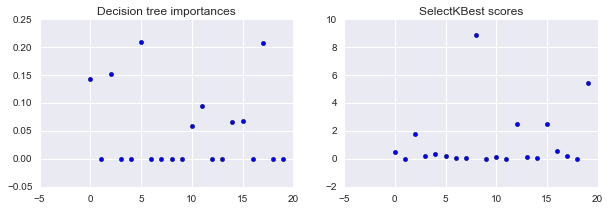

In [94]:
# visually inspect for high scores
fig, axes = plt.subplots(1,2, figsize=(10,3))

axes[0].scatter(x=range(features.shape[1]), y=clf.feature_importances_)
axes[0].set_title('Decision tree importances')

axes[1].scatter(x=range(features.shape[1]), y=kbest.scores_)
axes[1].set_title('SelectKBest scores');

Grid Search
-------

In [143]:
from sklearn.preprocessing import Normalizer

normer = Normalizer()
X_train = normer.fit_transform(X_train)
X_test = normer.transform(X_test)

In [145]:
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

f1_scorer = metrics.make_scorer(metrics.f1_score)

# Setup parameters and cross validation for model optimization through Grid Search
parameters = {'C': [pow(2, c) for c in range (-5, 11)],
              'gamma': [pow(2, g) for g in range (-5, 11)]
             }

# fit the grid object
grid_obj = GridSearchCV(SVC(), parameters, scoring=f1_scorer, cv=8)
grid_obj.fit(X_train, y_train)

# Select the best settings for classifier
best_clf = grid_obj.best_estimator_

# Fit the algorithm to the training data
print "Final Model: "
print best_clf, "\n"

# Test algorithm's performance
print "F1 score for training set: {}\n".format(metrics.f1_score(best_clf.predict(X_train), y_train))
print "F1 score for test set: {}\n".format(metrics.f1_score(best_clf.predict(X_test), y_test))
print classification_report(y_test, best_clf.predict(X_test))

Final Model: 
SVC(C=512, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=128, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

F1 score for training set: 1.0

F1 score for test set: 0.153846153846

             precision    recall  f1-score   support

          0       0.86      0.84      0.85        38
          1       0.14      0.17      0.15         6

avg / total       0.77      0.75      0.76        44



In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

---

Load the submission file 'poi_id.py'
--------------

Use command:  
**`%load poi_id.py`**

---

Enron Submission Free-Response [Questions](https://docs.google.com/document/d/1NDgi1PrNJP7WTbfSUuRUnz8yzs5nGVTSzpO7oeNTEWA/pub?embedded=true)
----------------------------------------

*1. Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]*

**Answer**:  

Enron was an energy company that at one time was one of the largest companies in the United States before going bankrupt due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. 

Using this financial and email data, we will build a classifier to identify whether or not an Enron employee was a "persons of interest" (POI) — individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity. The classifier will be trained on a portion of our data, using features we know about employees from the public record data (eg, salary, number of emails sent) and a label of whether an employee was a POI or not. This trained classifier will then be used on another portion of the data where we make predictions for whether an employee is a POI or not, and measure the classifier's accuracy by comparing the predictions against the actual labels of the employees.

__Data Exploration__:  
Our dataset has a total of 144 instances, with 18 that are POI's (ie, 12.5% of the data) — 2 items in `data_dict` were not utilized (1 was a TOTAL of all features, 1 had all null values).

Our analysis is performed with 19 features, although the `data_dict` actually has 20 features in total (the feature "email address" is removed). 

We have a number of NaN (null) values which we convert to 0:
    salary 51
    to_messages 60
    deferral_payments 107
    total_payments 21
    exercised_stock_options 44
    bonus 64
    restricted_stock 36
    shared_receipt_with_poi 60
    restricted_stock_deferred 128
    total_stock_value 20
    expenses 51
    loan_advances 142
    from_messages 60
    other 53
    from_this_person_to_poi 60
    director_fees 129
    deferred_income 97
    long_term_incentive 80
    email_address 35
    from_poi_to_this_person 60


__Outlier Investigation__:  
Visual inspection of each of the features using a boxplot showed a couple of notable outliers in the financial features. One turned out to be a "total" of each feature and was removed from the dataset. The other was Enron CEO Kenneth Lay, who was kept in the dataset. No outliers were removed in order to preserve the already small size of the dataset.

---
*2. What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “properly scale features”, “intelligently select feature”]*

**Answer**:  
First the features were scaled and/or normalized. 

Removed features based select K best, [low variance](http://scikit-learn.org/stable/modules/feature_selection.html). Trying to reduce the dimensionality of the data. `SelectKBest` feature score were as follows:
- kbest feature score

Created new features based on PCA dimensionality reduction and clustering.

Below are the feature importances of the random forest:
- feature importance


---
*3. What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]*


**Answer**:  
Logistic Regression:
- Look for a simple linear separation.

Naive Bayes:
- Small amount of data calls for a high bias classifier.

SVM:
- Good for predicting high dimension data.

Decision Tree:
- Non-linear separation that reveals feature importances.


---
*4. What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric item: “tune the algorithm”]*

**Answer**:  
Algorithm have parameters that can affect performance. Default parameters for many [sklearn estimators were benchmarked](http://partiallyderivative.com/podcast/2016/06/27/randy-olson-interview) with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, which isn't necessarily translatable to predicting other types of data and datasets (also see [new project to create sklearn benchmarks](https://github.com/rhiever/sklearn-benchmarks)).

Used grid search to tune the model.

Also experiemnts with TPOT to generate pipeline.


---
*5. *What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric item: “validation strategy”] Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]*

**Answer**:  
Validate using GridSearchCV. Classic mistake is running the grid search on full dataset rather than just training data.

Evaluated models looking at precision, recall, F1 score.

Explaining the metrics:
- Precision allows us to measure how accurate the model is when it actually predicts that an individual is a POI. Equal to number of correct hits divided by total guesses that a person is a POI.

- Recall shows how many of the POI's we identified out of all the POI's that exist. Equal to number of correct hits divided by total POI's that exist.

- F1 score gives an interpretation of precision and recall together so that we balance the ability to make accurate predictions (precision) vs not missing out on identifying possible POI's (recall). Equal to 2 times the product of precision and recall, divided by sum of precision and recall. 

$F_1 = 2 \times \frac{(Precision)(Recall)}{Precision + Recall} $


---
I hereby confirm that this submission is my work. I have cited above the origins of any parts of the submission that were taken from Websites, books, forums, blog posts, github repositories, etc.

---